In [239]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

### Read Images

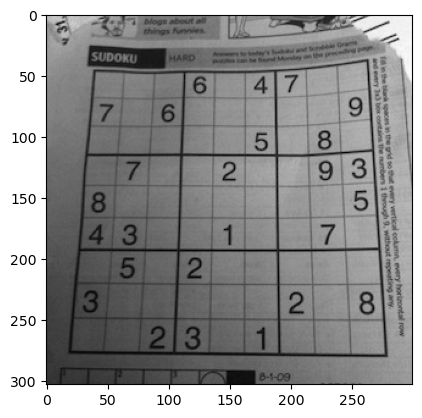

In [240]:
sudoku = cv2.imread('Images/lines.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(sudoku, cmap = 'gray')

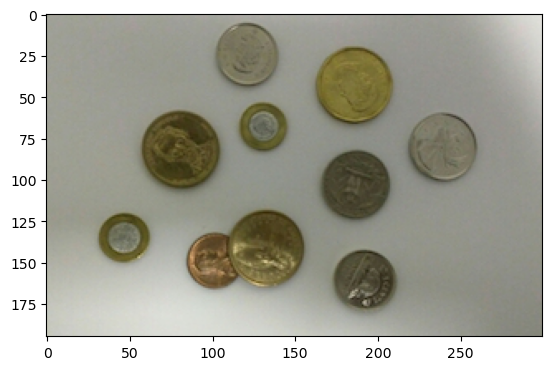

In [241]:
coins = cv2.imread('Images/circles.jpg')
coins = cv2.cvtColor(coins, cv2.COLOR_BGR2RGB)
plt.imshow(coins)

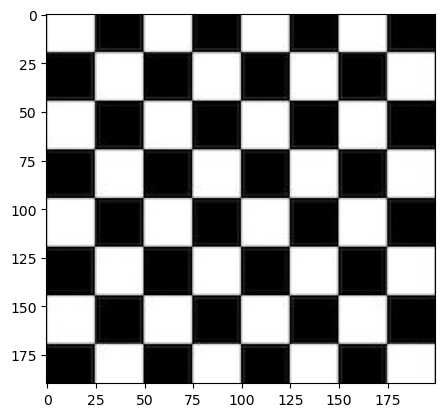

In [242]:
chess_pattern = cv2.imread('Images/corners.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(chess_pattern, cmap = 'gray')

## Task1: Hough Transform for Line Detection

In [243]:
# use canny to detect edges
sudoku_canny_edges = cv2.Canny(sudoku, 30, 150, 3)

In [244]:
sudoku_lines = cv2.HoughLines(sudoku_canny_edges, 1, (np.pi / 180), 150, None, 0, 0)
sudoku_lines.shape

(20, 1, 2)

In [245]:
import math

sudoku_bgr = cv2.cvtColor(sudoku, cv2.COLOR_GRAY2BGR)
sudoku_cp = np.copy(sudoku_bgr)

# plot lines
for i in range(0, len(sudoku_lines)):
    rho = sudoku_lines[i][0][0]
    theta = sudoku_lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x_0 = a * rho
    y_0 = b * rho
    pt_1 = (int(x_0 + 1000*(-b)), int(y_0 + 1000*(a)))
    pt_2 = (int(x_0 - 1000*(-b)), int(y_0 - 1000*(a)))
    cv2.line(sudoku_cp, pt_1, pt_2, (255, 0, 0), 1, cv2.LINE_AA)


Text(0.5, 1.0, 'Hough Lines')

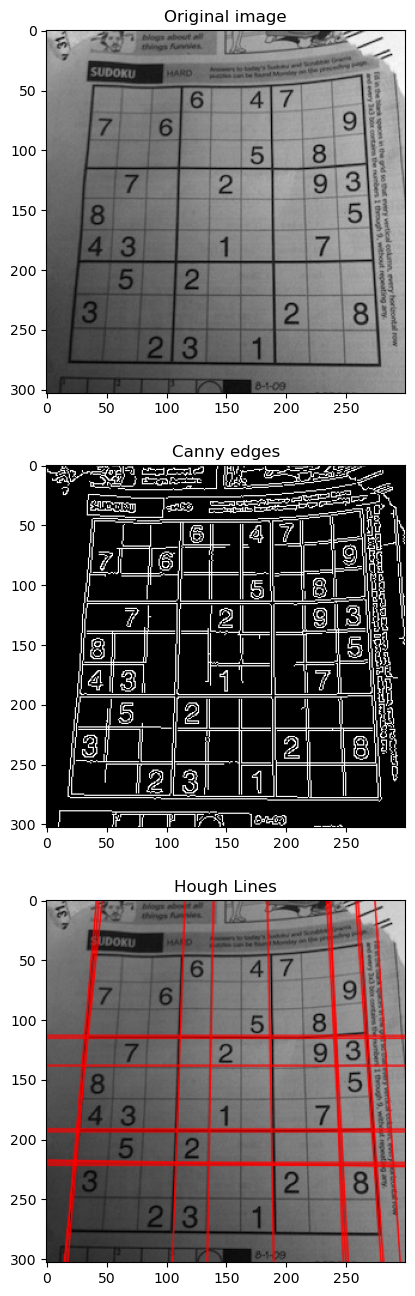

In [246]:
plt.figure(figsize = (16, 16))
plt.subplot(3, 1, 1)
plt.imshow(sudoku, cmap = 'gray')
plt.title('Original image')

plt.subplot(3, 1, 2)
plt.imshow(sudoku_canny_edges, cmap = 'gray')
plt.title('Canny edges')

plt.subplot(3, 1, 3)
plt.imshow(sudoku_cp)
plt.title('Hough Lines')

## Task 2: Hough Circle Detection from Scratch

In [247]:
# gets the indices of 'n' largest values in array
def get_n_largest_indices(arr, n):
    
    indices = []
    
    # Flatten the 3D array into a 1D array and get the indices of the n largest values
    flat_indices = np.argpartition(arr.ravel(), -n)[-n:]
    
    # Convert the 1D indices back to 3D indices
    indices_3d = np.unravel_index(flat_indices, arr.shape)
    
    for index in zip(*indices_3d):
        indices.append(index)      
    return indices
    
    
def get_hough_circles(img, g_k, t1, t2, n):
    # convery to gray
    coins_gray = cv2.cvtColor(coins, cv2.COLOR_RGB2GRAY)

    # apply filtering for better edge detection
    coins_gray_filt = cv2.GaussianBlur(coins_gray, (g_k, g_k), sigmaX = 1, sigmaY = 1)

    # get canny edges
    coins_canny_edges = cv2.Canny(coins_gray_filt, t1, t2, 2)
    
    # define paramters for accumulator space
    radii = range(15, 40, 2)
    theta = range(0, 360, 10)
    b_max, a_max = coins_canny_edges.shape
    r_max = len(radii)
    A = np.zeros((b_max, a_max, r_max))
    
    # for each radius
    for i, r in enumerate(radii):
        for y in range(b_max):     # row 
            for x in range(a_max):   # column
                
                # if edge pixel is found
                if coins_canny_edges[y][x] != 0:
                    
                    # calculate all possible values of a and b
                    for theta in range(0, 361, 10):
                        
                        b = int(y - r * np.sin(np.deg2rad(theta)))
                        a = int(x - r * np.cos(np.deg2rad(theta)))
                        
                        if a < a_max and b < b_max:
                            
                            # increase vote
                            A[b, a, i] += 1
                                
    # get indices of 'n' largest values
    max_val_indices = get_n_largest_indices(A, n)
    
    # remove any circles that are too close to each other
    list_len = len(max_val_indices)
    items_to_remove = []
    for i in range(list_len - 1):
        for j in range(i+1, list_len):
            a1, b1, r1 = max_val_indices[i]
            a2, b2, r2 = max_val_indices[j]
            if abs(r1 - r2) <= 2 and abs(a1 - a2) <= 2 and abs(b1 - b2) <= 2:
                items_to_remove.append(max_val_indices[j])             
    
    for val in items_to_remove:
        if val in max_val_indices:
            max_val_indices.remove(val)
            
    # plot circles on original image
    coins_cpy = np.copy(coins)
    for y, x, r in max_val_indices:
        radius = radii[r]
        cv2.circle(coins_cpy, (x, y), radius, (255, 0, 0), 1)
        
    return coins_cpy


In [248]:
gaussian_kernel = 5  # gaussian kernel size
canny_thresh1 = 75   
canny_thresh2 = 200
n_circles = 40       # number of circles to use for nonmax suppression
hough_circles = get_hough_circles(coins, gaussian_kernel, canny_thresh1, canny_thresh2, n_circles)

Text(0.5, 1.0, 'Hough Circles')

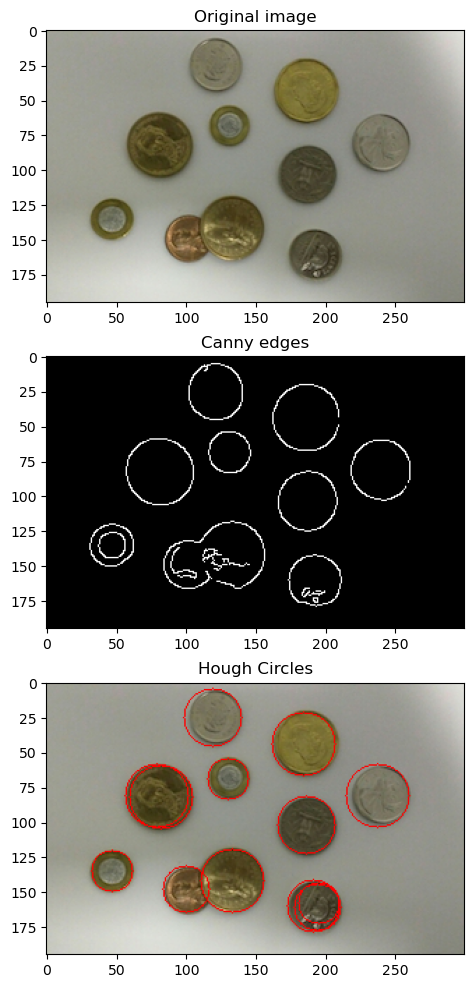

In [249]:
plt.figure(figsize = (14, 12))
plt.subplot(3, 1, 1,)
plt.imshow(coins)
plt.title('Original image')

plt.subplot(3, 1, 2)
plt.imshow(coins_canny_edges, cmap = 'gray')
plt.title('Canny edges')

plt.subplot(3, 1, 3)
plt.imshow(hough_circles)
plt.title('Hough Circles')

## Task 3: Harris Corner Detection from scratch

In [250]:
def apply_nonmax_suppression(img, R_thresh):
    window_size = 3  # window size for non_max suppression
    r, c = img.shape
    binary_img = np.zeros_like(img, dtype = np.int8)
    for i in range(int(np.floor(window_size/2)), r - window_size + 1):
        for j in range(int(np.floor(window_size/2)), c - window_size + 1):
            
            # if corner pixel
            if img[i, j] >= R_thresh:
                val_a = img[i, j+1]
                val_b = img[i+1, j+1]
                val_c = img[i+1, j]
                val_d = img[i-1, j-1]
                val_e = img[i, j-1]
                val_f = img[i-1, j-1]
                val_g = img[i-1, j]
                val_h = img[i-1, j+1]
                       
                # if current value is greater than all surrounding values in the image, keep corner pixel
                if max([val_a, val_b, val_c, val_d, val_e, val_f, val_g, val_h]) <= img[i, j]:
                    binary_img[i, j] = 1
                else:
                    binary_img[i, j] = 0
            
    return binary_img

def get_corner_locations(img):
    max_val = np.max(img)
    max_mask = (img == max_val)

    # Find the indices where the maximum values occur
    max_indices = np.argwhere(max_mask)

    return max_indices


def detect_harris_corner(img, window_size, r_c, R_thresh):
    stride = int(1)
    
    # apply gaussian filter
    # img_blur = cv2.GaussianBlur(img, (3, 3), sigmaX = 1, sigmaY = 1)
    
    # define kernels for gradient calculation
    ddepth = cv2.CV_32F
    k_x = np.array([[1, 0, -1]]).reshape(1,3)
    k_y = np.array([[1,0,-1]]).reshape(3,1)
    sobel_x = cv2.filter2D(img, ddepth, k_x)
    sobel_y = cv2.filter2D(img, ddepth, k_y)

    # center gradient images
    sobel_x = sobel_x - np.mean(sobel_x)
    sobel_y = sobel_y - np.mean(sobel_y)

    # initalize array to store response
    res_size_r = int((img.shape[0] - window_size)/stride)
    res_size_c = int((img.shape[1]- window_size)/stride)
    response_arr = np.zeros((res_size_r, res_size_c))

    for i in range(0, img.shape[0] - window_size + 1):
        for j in range(0, img.shape[1] - window_size + 1):
            Ix = sobel_x[i:i+window_size, j:j+window_size]
            Iy = sobel_y[i:i+window_size, j:j+window_size]

            # calculate Ix*Ix, Iy*Iy and Ix*Iy
            Ix2 = np.square(Ix)
            Iy2 = np.square(Iy)
            Ixy = Ix*Iy

            # get sum
            Sx2 = np.sum(Ix2)
            Sy2 = np.sum(Iy2)
            Sxy = np.sum(Ixy)

            # define matrix
            M = np.array([[Sx2, Sxy],[Sxy, Sy2]])
            eig_vals = np.linalg.eig(M)[0]

            # get eigenvalues
            lambda1 = eig_vals[0]
            lambda2 = eig_vals[1]

            # get det and trace
            det = lambda1*lambda2
            trace = lambda1 + lambda2

            try:
                # fill response arr
                response_arr[i][j] = det - r_c*(trace**2)

            except IndexError as e:
                pass

    res_min = np.min(response_arr)
    res_max = np.max(response_arr)
    response_arr = (response_arr - res_min)/(res_max - res_min)
    pad_height = window_size
    pad_width = window_size
    pad_dim = ((pad_height, pad_height), (pad_height, pad_width))
    padded_img = np.pad(response_arr, pad_dim, mode = 'constant', constant_values = 0)

    # apply thresholding
    __, thresh_img = cv2.threshold(response_arr,R_thresh,1,cv2.THRESH_TOZERO)
    
    # apply non-max suppression
    supp_img = apply_nonmax_suppression(thresh_img, R_thresh)
    
    # get corner locations
    corner_indices = get_corner_locations(supp_img)
    
    # convert original image to color image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # for every corner location
    for r, c in corner_indices:
        # set red channel to max and other to zero
        img_rgb[r, c, 0] = 255
        img_rgb[r, c, 1] = 57
        img_rgb[r, c, 2] = 15
    
    return sobel_x, sobel_y, response_arr, supp_img, img_rgb

In [251]:
window_size = 3  # window size for corner detection
R_thresh = 0.7   # threshold for response value
r_c = 0.07       # response constant
img = chess_pattern
Ix, Iy, response_arr, nonmax_suppression, corners = detect_harris_corner(img, window_size, r_c, R_thresh)

Text(0.5, 1.0, 'dy')

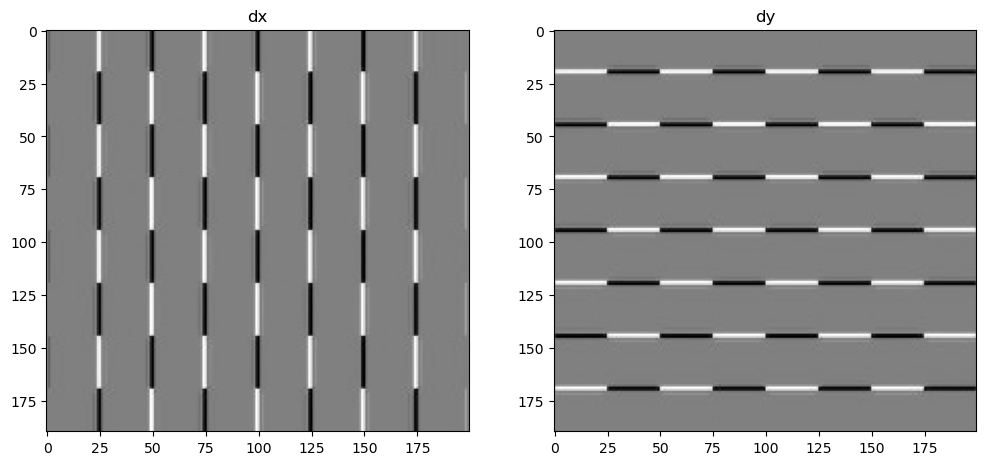

In [252]:
plt.figure(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(Ix, cmap = 'gray')
plt.title('dx')

plt.subplot(1, 2, 2)
plt.imshow(Iy, cmap = 'gray')
plt.title('dy')

Text(0.5, 1.0, 'thresholding + nonmax suppression')

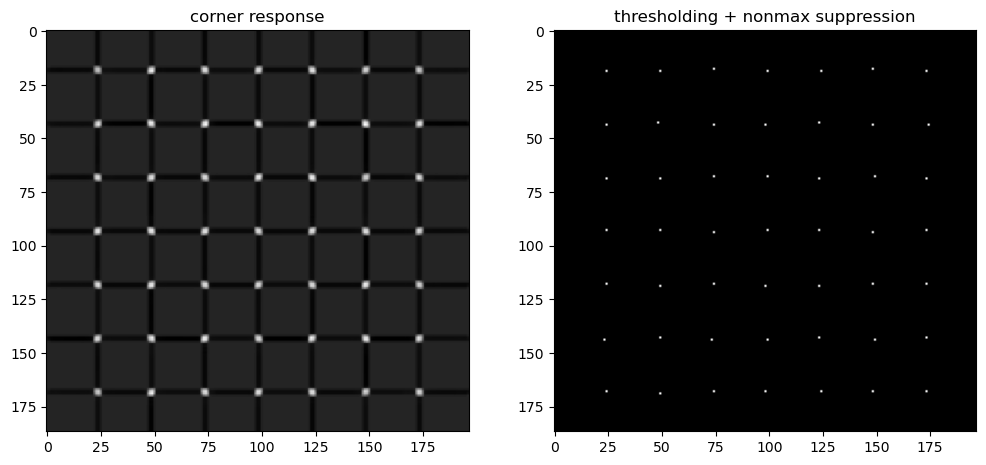

In [253]:
plt.figure(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(response_arr, cmap = 'gray')
plt.title('corner response')

plt.subplot(1, 2, 2)
plt.imshow(nonmax_suppression, cmap = 'gray')
plt.title('thresholding + nonmax suppression')

Text(0.5, 1.0, 'Corners Detected in RED')

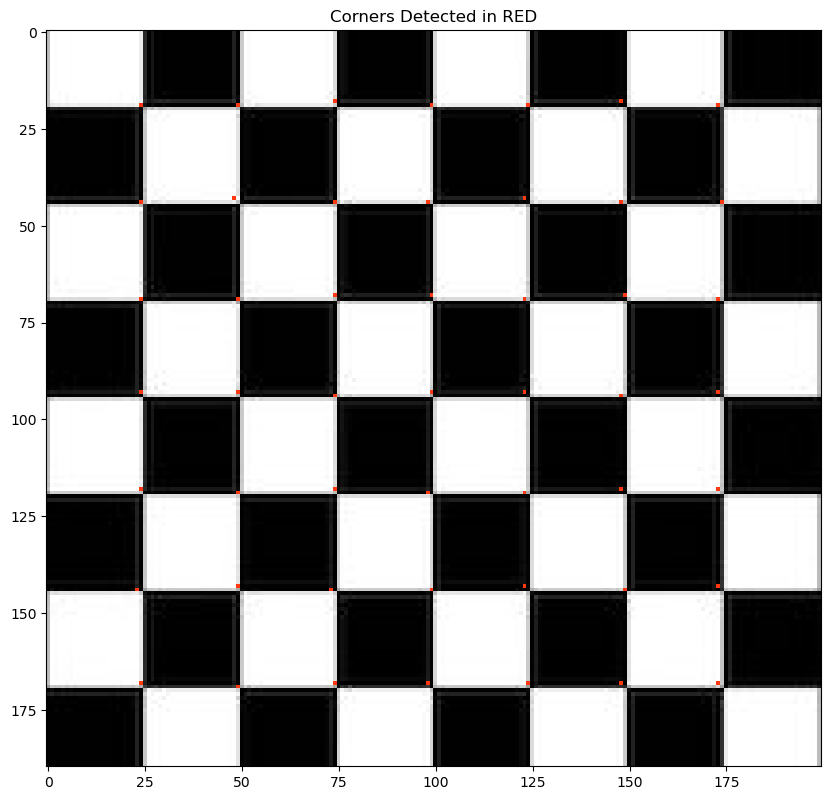

In [254]:
plt.figure(figsize = (10, 10))
plt.imshow(corners)
plt.title('Corners Detected in RED')